#### 环境配置

In [1]:
# print(sss)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive/4位数字验证码识别')

In [3]:
!pip install captcha

#### 导入包

In [0]:
import os
import tensorflow as tf
from tensorflow.contrib import slim
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from PIL import Image
from captcha.image import ImageCaptcha
import sys

In [0]:
dataset_dir = './test_images/'
inputs = tf.placeholder(tf.float32, [1,224,224,3])
num_classes = 10

#### 生成测试集图片
根据训练集，找了10张训练集中没有的，主要是防止数据泄露

In [0]:
print(sss)

test_list = ['0006', '0548', '0979', '2134', '9999', '9256', '7819', '6666', '8888', '5678']
def generateImages(test_list):
    for i in range(len(test_list)):
        image = ImageCaptcha()
        captcha = image.generate(test_list[i])
        image.write(test_list[i], 'test_images/'+test_list[i]+'.jpg')    # 将生成的验证码图片写入文件夹
        sys.stdout.write('\r>>Create image {}-{}'.format(i, len(test_list)))
        sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()
generateImages(test_list)

>>Create image 9-10


#### 模型训练

##### 预处理

In [0]:
# 获得所有测试的验证码的路径
def get_filenames(dataset_dir):
    path = []
    for filename in os.listdir(dataset_dir):
        image_path = os.path.join(dataset_dir, filename)
        path.append(image_path)
    return path

In [0]:
images_path = get_filenames(dataset_dir)

In [8]:
images_path

['./test_images/0548.jpg',
 './test_images/0979.jpg',
 './test_images/2134.jpg',
 './test_images/9999.jpg',
 './test_images/9256.jpg',
 './test_images/7819.jpg',
 './test_images/6666.jpg',
 './test_images/8888.jpg',
 './test_images/5678.jpg',
 './test_images/0006.jpg']

##### 测试模型

In [0]:
def AlexNet(inpus, is_training=True):
    with slim.arg_scope([slim.conv2d, slim.fully_connected], 
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.glorot_uniform_initializer(),
                        biases_initializer=tf.constant_initializer(0)
                       ):
        net = slim.conv2d(inputs, 64, [11,11], stride=4)
        net = slim.max_pool2d(net, [3,3])
        net = slim.conv2d(net, 192, [5,5])
        net = slim.max_pool2d(net, [3,3])
        net = slim.conv2d(net, 384, [3,3])
        net = slim.conv2d(net, 384, [3,3])
        net = slim.conv2d(net, 256, [3,3])
        net = slim.max_pool2d(net, [3,3])
        
        net = slim.flatten(net)
        net = slim.fully_connected(net, 4096)
        net = slim.dropout(net, is_training=is_training)
        
        net0 = slim.fully_connected(net, num_classes, activation_fn=tf.nn.softmax)
        net1 = slim.fully_connected(net, num_classes, activation_fn=tf.nn.softmax)
        net2 = slim.fully_connected(net, num_classes, activation_fn=tf.nn.softmax)
        net3 = slim.fully_connected(net, num_classes, activation_fn=tf.nn.softmax)
        
        return net0, net1, net2, net3

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/model.ckpt-300


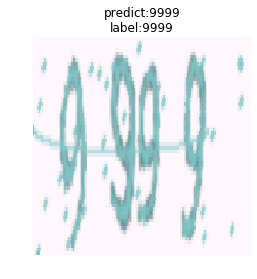

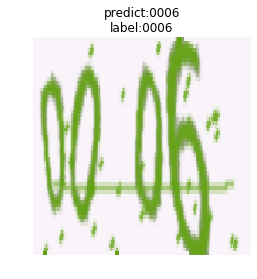

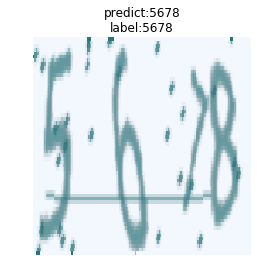

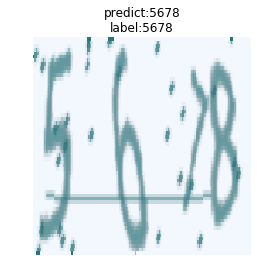

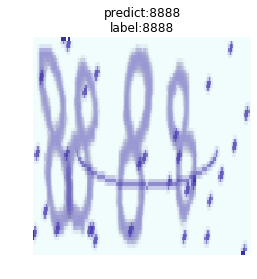

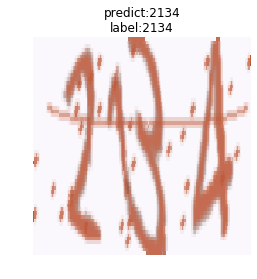

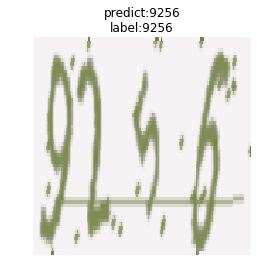

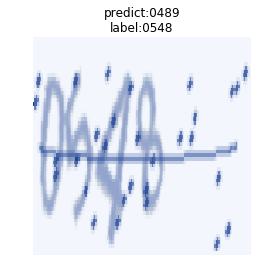

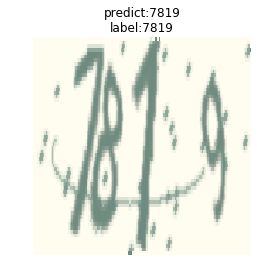

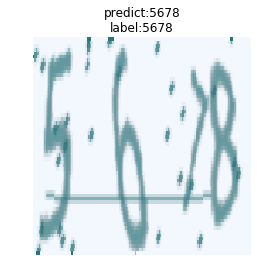

In [10]:
with tf.Session() as sess:
    logit0, logit1, logit2, logit3 = AlexNet(inputs, False)
    pred0 = tf.argmax(logit0, 1)
    pred1 = tf.argmax(logit1, 1)    
    pred2 = tf.argmax(logit2, 1)    
    pred3 = tf.argmax(logit3, 1)
    sess.run(tf.global_variables_initializer())
    
    # 载入模型
#     saver = tf.train.import_meta_graph('models/model.ckpt.meta')
    saver = tf.train.Saver()
#     saver.restore(sess, 'models/9_8/9_8_2_model.ckpt')
    saver.restore(sess, 'models/model.ckpt-300')
#     is_training = sess.graph.get_tensor_by_name('Placeholder:0')
#     inputs = sess.graph.get_tensor_by_name('Placeholder:1')
    
    
    for i in range(10):
        filename = choice(images_path)
        image = Image.open(filename)
        image = image.resize((224,224))
        image = np.array(image)
        
        image_data = image /255.0
        image_data = image_data - 0.5
        image_data = image_data * 2
        image_data = image_data.reshape((1,224,224,3))
        
        pre0, pre1, pre2, pre3 = sess.run([pred0, pred1, pred2, pred3], feed_dict={inputs:image_data})
        
        label = filename.split('/')[-1][:4]
        plt.imshow(image)
        plt.axis('off')
        plt.title('predict:'+ str(pre0[0])+str(pre1[0])+str(pre2[0])+str(pre3[0]) + '\n' + 'label:' + label)
        plt.show()

#### 总结

生成的文件是ckpt文件，由于一开始保存模型时，没有给tensor添加名字，所以在进行测试加载模型时费了一些功夫，模型文件中的tensor名由于是当时训练时第一次出错，没有重启直接第二次，系统默认给再次运行的tensor换了名字（0,1,2,3...），所以导致后面进行验证时重新训练了模型。